In [1]:
import os
import pandas as pd
from pandas import DataFrame
from keras.models import Sequential, Model, Sequential, load_model, Input
from keras.layers import Dense, Input, Activation, Conv2D, MaxPool2D, Flatten, UpSampling2D, Conv2DTranspose, Reshape, LeakyReLU, Concatenate
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils, plot_model
from keras import backend as K
import matplotlib.pyplot as plt
# matplotlib.use("TkAgg")
%matplotlib inline
import numpy as np
np.random.seed(1)
from sklearn.metrics import confusion_matrix
from PIL import Image
import random
import math

Using TensorFlow backend.


In [2]:
if not os.path.exists('model/'):
    os.makedirs('model/')

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('x_train\n', X_train.shape)
print('y_train\n', y_train.shape, y_train[0])
print('x_test\n', X_test.shape)
print('y_test\n', y_test.shape)

x_train
 (60000, 28, 28)
y_train
 (60000,) 5
x_test
 (10000, 28, 28)
y_test
 (10000,)


In [4]:
digit_size = 28
channels = 1

# data pre-processing
X_train = X_train.astype('float32') / 255       # minmax_normalized
X_test = X_test.astype('float32') / 255         # minmax_normalized
X_train = X_train.reshape((-1, digit_size, digit_size, channels))
X_test = X_test.reshape((-1, digit_size, digit_size, channels))
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
input_img = Input(shape=(digit_size, digit_size, channels))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPool2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

input_ec = Input(shape=(4, 4, 8)) 
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_ec)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)

encoder = Model(inputs=input_img, outputs=encoded)
decoder = Model(input_ec, decoded)

# del encoder
# encoder = load_model('model/encoder.h5')
# del decoder
# decoder = load_model('model/decoder.h5')

ec_out = encoder(input_img)
dc_out = decoder(ec_out)
autoencoder = Model(input_img, dc_out)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

encoder.summary()
decoder.summary()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
Total para

In [6]:
# training
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True)

encoder.save('model/encoder.h5')
decoder.save('model/decoder.h5')

W0708 15:19:21.730290 4750738880 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
60000/60000 [==============================] - 37s 624us/step - loss: 0.2482
Epoch 2/10
60000/60000 [==============================] - 31s 515us/step - loss: 0.1754
Epoch 3/10
60000/60000 [==============================] - 25s 424us/step - loss: 0.1604
Epoch 4/10
60000/60000 [==============================] - 29s 476us/step - loss: 0.1506
Epoch 5/10
60000/60000 [==============================] - 28s 467us/step - loss: 0.1445
Epoch 6/10
60000/60000 [==============================] - 27s 443us/step - loss: 0.1400
Epoch 7/10
60000/60000 [==============================] - 23s 384us/step - loss: 0.1362
Epoch 8/10
60000/60000 [==============================] - 25s 423us/step - loss: 0.1329
Epoch 9/10
60000/60000 [==============================] - 23s 384us/step - loss: 0.1303
Epoch 10/10
60000/60000 [==============================] - 23s 384us/step - loss: 0.1284


(10, 28, 28, 1)


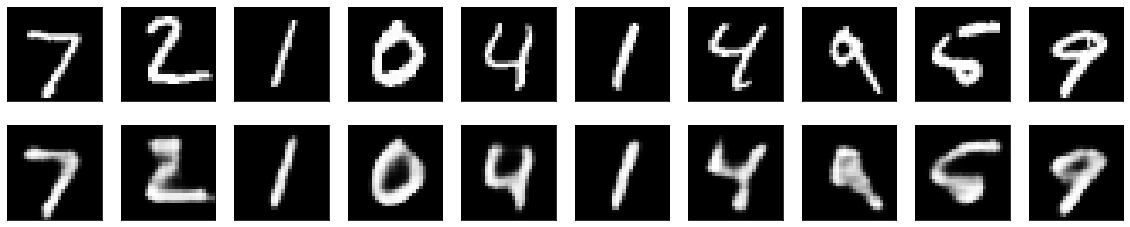

In [7]:
n = 10
decoded_imgs = autoencoder.predict(X_test[:n])
print(decoded_imgs.shape)
  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(digit_size, digit_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(digit_size, digit_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

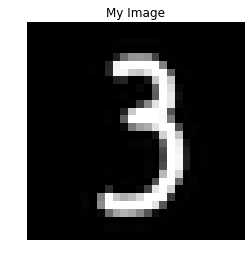

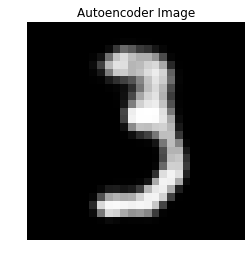

In [8]:
from PIL import Image
im = Image.open("./media/n_3.png")
im = im.convert('L') # 轉成灰階
im = im.resize((digit_size, digit_size), Image.ANTIALIAS) # resize the image
im = np.array(im) #convert to an array
im2 = im.astype('float32') / 255 # normalise input
# 畫圖
plt.imshow(im2, cmap='gray')
plt.title('My Image')
plt.axis('off')
plt.show()

test_image = np.reshape(im2, [1, digit_size, digit_size, channels]) # reshape it to our input placeholder shape
d_ = autoencoder.predict(test_image)
# 畫圖
plt.imshow(np.reshape(d_, (digit_size, digit_size)), cmap='gray')
plt.title('Autoencoder Image')
plt.axis('off')
plt.show()